In [14]:
#literally everything
import numpy as np
#for plotting our histograms, contours and lines
import matplotlib.pyplot as plt
#for making dataframes
import pandas as pd
#lets us use probability distributions like t, beta, gamma,etc.
from scipy.stats import norm, expon, poisson, uniform, nbinom, gamma

In [15]:
#PROBLEM 3 (BDA 3rd. Ed. 1.9)

In [19]:
def poisson_process(l,time,a,b,num): 
  '''
  ### MODEL PARAMETERS
  # l - rate parameter
  # time - time period we're interested in (lambda and time must be same scale)
  # a, b - time interval of time spent with patient. i.e. U ~ uniform(a,b)
  # num - number of doctors in the clinic
  '''
  #samples 10*mean(Poisson(lambda*t)) from T ~ Exp(lambda) and sums them. 
  arr_T = np.cumsum(expon.rvs(size=10*int(time/l),scale=l))
  #remove anything exceeding time. we don't take patients after that
  arr_T = np.array([x for x in arr_T if x <= time])
  # records appointment duration wrt opening time
  doc = np.repeat(0.0,num) #must be 0.0 to allow for floats.
  wait = []
  for j in range(len(arr_T)): 
      # waiting time of patient j
      wait.append(doc.min() - arr_T[j])
      #appointment duration
      u = uniform.rvs(size=1, loc=a, scale=b-a)
      doc[doc.argmin()] = np.array([doc.min() if wait[j]>0 else arr_T[j]]) + u
  #if wait <= 0, they didn't wait. If wait > 0, they did
  number_waited = sum([ 1 if x>0 else 0 for x in wait])
  #waiting time is simply sum of positive waiting times
  time_waiting = sum([ x if x>0 else 0 for x in wait])
  #clinic closes either at 4:00pm, or when they finish
  closing_time = np.max([doc.max(),time])
  #in the case that no one waits on a doctor
  avg_wait_time = [ 0 if number_waited==0 else time_waiting / number_waited]
  ### STORES OUR INFORMATION
  df  = {
        'Number of Arrivals': [len(arr_T)],
        'Number of Patients': number_waited,
        'Average Waiting Time': avg_wait_time,
        'Closing Time': closing_time
                   } 
  df = pd.DataFrame(df)
  return(df)

In [20]:
# PART A
print(poisson_process(l=10,time=420,a=15,b=20,num=3))

   Number of Arrivals  Number of Patients  Average Waiting Time  Closing Time
0                  49                  14              5.643469    436.681475


In [21]:
#PART B 
#gets samples (note:_ convention for a variable whose value you don't care for)
w = [poisson_process(l=10,time=420,a=15,b=20,num=3) for _ in range(101)]
w = pd.concat(w)

#so we can see all the data
pd.set_option("display.max_columns", 4)
#find quantiles over columns
print(np.round(w.quantile([0.25,0.50,0.75], axis = 0),2))

      Number of Arrivals  Number of Patients  Average Waiting Time  \
0.25                39.0                 8.0                  5.25   
0.50                43.0                12.0                  6.48   
0.75                46.0                18.0                  8.39   

      Closing Time  
0.25        425.67  
0.50        432.98  
0.75        436.73  


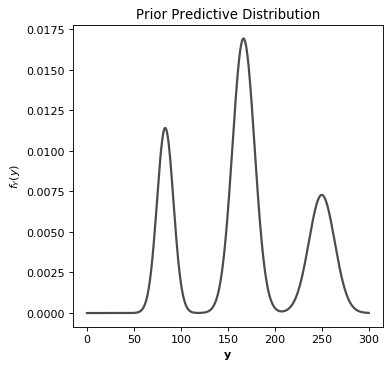

In [22]:
### PROBLEM 4 (BDA 3rd. Ed. 2.4)

#values that we want to plug in for our pdf
y = np.linspace(start=0, stop=300, num=1000)
#normal approx. to binomial
def fy(x,theta) : 
    mu = 1000*theta; sd = np.sqrt(1000*theta*(1-theta))
    return norm.pdf(x, loc = mu, scale = sd)

#sample space of parameter theta
theta_values = np.array([1/12,1/6,1/4])
#probability associated with each value of theta
theta_probs = np.array([0.25,0.5,0.25])

#does matrix multiplication. (1000x3)(2x1) -> 1000x1 vector
p = fy(y[:,None], theta_values).dot(theta_probs)

# Draw Plot
plt.figure(figsize=(5,5), dpi= 80) #dimensions of figure

ax = plt.axes() # Setting the background color of the plot 
ax.set_facecolor("white") # using set_facecolor() method

plt.plot(y,p,color="black",alpha=0.7,linewidth=2)
plt.xlabel('y',fontweight='bold')
plt.ylabel("$f_{Y}(y)$",fontweight='bold')
plt.title('Prior Predictive Distribution')
plt.show()

In [25]:
#Note, use 0.9999 for the quantiles in between. 1 gives you Infinity
q = [0.20,0.99997,0.50,0.9996,0.80]
mu_theta = np.array([1/12,1/12,1/6,1/6,1/4])
sd_theta = np.sqrt(1000*mu_theta*(1-mu_theta))

Q = norm.ppf(q,loc = 1000*mu_theta,scale = sd_theta)

#put into dataframe so it looks nice
Q = pd.DataFrame(np.round(Q,3).reshape(1,5),
                 columns= ["5%","25%","50%","75%","95%"])
#so we can see all the data
pd.set_option("display.max_columns", 5)
print(Q)

       5%      25%      50%     75%      95%
0  75.978  118.406  166.667  206.18  261.524


In [26]:
#METHOD 2:

# GMQ- Gaussian Mixture Quantiles. Uses line search to find roots
def GMQ(p,theta,w,y,tol):
    #cdf function
  def gmm(x,theta) : 
    mu = 1000*theta; sd = np.sqrt(1000*theta*(1-theta))
    return norm.cdf(x, loc = mu, scale = sd)
  #y values to plug into cdf; 
  x = np.arange(0,y+tol,tol)
  #values of function cdf(y)- q; length of quantile
  mass = gmm(x[:,None], theta).dot(w); n = len(p)
  ww = abs(mass[:,None]-p[None,:])
  quantile = x[ww.argmin(axis=0)]
  #names the quantiles we're looking for
  quantile_names = [str(100*p[j])+'%' for j in range(n)]
  #Nice, readable form
  quantiles = pd.DataFrame(quantile.reshape(1,n),
                            columns = quantile_names)
  return quantiles 

#quantile values
GMQ(p=np.array([0.05,0.25,0.50,0.75,0.95]),
    theta=theta_values,
    w=theta_probs,
    y=500,
    tol = 0.01)

,5.0%,25.0%,50.0%,75.0%,95.0%
0,75.98,118.0,166.67,206.45,261.52


In [27]:
### PROBLEM 6 (BDA 3rd. Ed. 2.8)

#functions for mean and variance of posterior
def var_n(n,a,b): return 1/(1/(a)**2 + n/(b)**2)
def mu_n(n,a,b,m,y): return var_n(n,a,b)*(m/(a)**2 + (n*y)/(b)**2)

mu = mu_n(n=np.array([10,10,100,100]),a=40,b=20,m=180,y=150)
var = var_n(n=np.array([10,10,100,100]),a=40,b=20)+np.array([0,20**2,0,20**2])

norm_ci = norm.ppf([0.025,0.975],loc = mu[:,None],scale = np.sqrt(var[:,None]))
norm_ci = np.round(norm_ci, 2) 
print(f"The 95% posterior interval for part c is {norm_ci[0,:]}, "
      f"the 95% predictive interval for part c is {norm_ci[1,:]}, "
      f"the 95% posterior interval for part d is {norm_ci[2,:]}, and "
      f"the 95% predictive interval for part d is {norm_ci[3,:]}.")

The 95% posterior interval for part c is [138.49 162.98], the 95% predictive interval for part c is [109.66 191.8 ], the 95% posterior interval for part d is [146.16 153.99], and the 95% predictive interval for part d is [110.68 189.47].


In [28]:
### PROBLEM 7 (BDA 3rd. Ed. 2.10)

#what we sum from and to
values = np.arange(203,10000)

#normalizing constant
prob_X = sum((1/(values))*(1/100)*(99/100)**(values - 1))
print(f"The Normalizing Constant for the Posterior is {round(prob_X,5)}")

#posterior distribution p(N|X)
post = (1/(100*prob_X*values))*(99/100)**(values - 1)

#E(N|X), i.e. posterior mean
mu_N =  sum(values*post)
print(f"The Posterior Mean is {round(mu_N,5)}")

#Var(N|X) = E(N^2|X)-(E(N|X))^2, i.e. posterior variance
sd_N = np.sqrt(sum(((values-mu_N)**2)*post))
print(f"The Posterior Standard Deviation is {round(sd_N,5)}")

The Normalizing Constant for the Posterior is 0.00047
The Posterior Mean is 279.08851
The Posterior Standard Deviation is 79.96458


In [29]:
#part c
#for computing the factorial
from scipy.special import gammaln

# Part c (Poisson Prior)

#q(N|X), unnormalized posterior
#put everything in terms of log and exponents so R can handle computation
post = np.exp(values*np.log(100)-gammaln(values)-100-np.log(values))
#p(X)
p_X1 = sum(post)
#p(N|X)
new_post = post/p_X1
#E(N|X)
mu_N1 =  sum(values*new_post)
print(f"The Posterior Mean is {round(mu_N1,5)}")

#sd(N|X)
sd_N1 = np.sqrt(sum((values-mu_N1)**2*new_post))
print(f"The Posterior Standard Deviation is {round(sd_N1,5)}")

The Posterior Mean is 203.94468
The Posterior Standard Deviation is 1.34385


In [30]:
### PROBLEM 8 (BDA 3rd Ed. 2.13)

### STORES OUR INFORMATION

df  = {
       'Accidents':np.array([24, 25, 31, 31, 22, 21, 26, 20, 16, 22]),
       'Deaths': np.array([734, 516, 754, 877, 814, 362, 764, 809, 223, 1066]),
       'Year': np.arange(1,11),
       'Death Rate': np.array([0.19, 0.12, 0.15, 0.16, 0.14,
                               0.06, 0.13, 0.13, 0.03, 0.15])
                   } 
df = pd.DataFrame(df)

#Adds new column of miles flown
df['Miles'] = df['Deaths']*1e8 / df['Death Rate']

#Prior distribution parameters
prior_shape = 0; prior_rate = 0

## APPROACH 1: FIND POSTERIOR PREDICTIVE DISTRIBUTION
#part a,b, c and d
#size parameter for negative binomial
sizes =  np.array([df['Accidents'].sum(),df['Accidents'].sum(),
                  df['Deaths'].sum(),df['Deaths'].sum()]) + prior_shape
    
#corresponding probability parameters
pr = np.array([df.shape[0]/(df.shape[0]+1+prior_rate),
                 df['Miles'].sum()/(df['Miles'].sum()+(8e11)+prior_rate),
                 df.shape[0]/(df.shape[0]+1+prior_rate),
                 df['Miles'].sum()/(df['Miles'].sum()+(8e11)+prior_rate)])
    
nbinom_ci = nbinom.ppf([0.025,0.975],n = sizes[:,None], p= pr[:,None]) 
print(f"The 95% predictive interval for part a is {nbinom_ci[0,:]}, "
      f"the 95% predictive interval for part b is {nbinom_ci[1,:]}, "
      f"the 95% predictive interval for part c is {nbinom_ci[2,:]}, and "
      f"the 95% predictive interval for part d is {nbinom_ci[3,:]}.")

The 95% predictive interval for part a is [14. 34.], the 95% predictive interval for part b is [22. 46.], the 95% predictive interval for part c is [638. 747.], and the 95% predictive interval for part d is [ 904. 1034.].


In [31]:
## APPROACH 2: SAMPLE FROM POSTERIOR, PLUG BACK INTO LIKELIHOOD
#Strategy:
#(sample from theta|y, plug values  into y|theta, sort from least to greatest)
#find 25th and 975th place, these represent endpoints of 95% posterior interval

#sample size and quantiles (recall python index starts at 0)
N = 1000; q = [24,974]

#shape parameter (notice this is also size parameter for negative binomial)
a = np.array([df['Accidents'].sum(),df['Accidents'].sum(),
                  df['Deaths'].sum(),df['Deaths'].sum()]) + prior_shape
#rate parameter
b = np.array([1/(df.shape[0]+ prior_rate), 1/(df['Miles'].sum()+ prior_rate),
             1/(df.shape[0]+ prior_rate), 1/(df['Miles'].sum()+ prior_rate)]) 

#miles proportion
m  = np.array([1,(8e11),1,(8e11)])

#samples from posterior, multiplies by m_j
l=[m[j]*gamma.rvs(size=N, a=a[j], scale=b[j]) for j in range(len(a))]
#puts samples into likelihood, sorts from least to greatest
l = np.array([sorted(poisson.rvs(size=N, mu = l[j])) for j in range(len(a))])
post_ci = l[:,q]
print(f"The 95% predictive interval for part a is {post_ci[0,:]}, "
      f"the 95% predictive interval for part b is {post_ci[1,:]}, "
      f"the 95% predictive interval for part c is {post_ci[2,:]}, and "
      f"the 95% predictive interval for part d is {post_ci[3,:]}.")

The 95% predictive interval for part a is [15 35], the 95% predictive interval for part b is [22 46], the 95% predictive interval for part c is [644 745], and the 95% predictive interval for part d is [ 905 1036].
